**This script takes the best models and features from Phase 1 of the model selection process and undertakes a deeper dive in reviewing/selecting the optimal models.  It also adapts wrangling steps to a Pipeline and embeds that pipeline in the fit_and_evaluate function from Dr. Bengfort's WheatClassification lab.**

To-Do:
- Use balanced sample of 50K observations DONE
- Align features across scripts DONE for outcome variable - PENDING for features (uniformly scale, reformat, normalize as we consolidate code---regularization)
- Substitute dummies for label encoding, create a pipeline DONE except for two where I need guarateed "1" values
- Add CV with 12 folds and randomized splits DONE
- Review validation curve, precision versus recall (Precision and Recall - DONE)
- Robustness checks for county_type versus MSA binary, state features PENDING - Will do on 8/28
- Grid search PENDING - Will do on 8/28
- Analyses on all years
- Test for collinearity (heat map)
-----
Week of 9/3:
- Holdout sets
- Review learning curve

In [1]:
%matplotlib inline 

import os
import json 
import time
import pickle
import pandas as pd 
import seaborn as sns

from sklearn.datasets.base import Bunch
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.exceptions import NotFittedError
from sklearn import metrics

from sklearn.model_selection import StratifiedKFold #ensure allows for randomization
from sklearn.model_selection import train_test_split as tts #drop this if using KFold
from sklearn import preprocessing
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.classifier import ClassificationReport

import warnings
warnings.filterwarnings("ignore")

**Read in data, create the two binaries that I have to create outside the Pipeline**

In [2]:
filepath = os.path.abspath(os.path.join( "..", "fixtures", "hmda2017sample_balanced.csv"))
DATA = pd.read_csv(filepath, low_memory=False)

DATA['locality_type'] = None
cloc = DATA.columns.get_loc('locality_type')
i = 0
for x in DATA['msamd_name'].isna():
    if x == True:
        DATA.iat[i, cloc]= 0
        
    else: 
        DATA.iat[i, cloc]= 1
        
    i+=1
        
DATA['locality_type'] = DATA['locality_type'].astype('int64')

DATA['action_taken'] = DATA.action_taken_name.apply(lambda x: 1 if x in ['Loan purchased by the institution', 'Loan originated'] else 0)

DATA['applicant_income_000s'].fillna(DATA.hud_median_family_income.median(), inplace=True)

remove = ['purchaser_type_name',
        'preapproval_name',
        'rate_spread', 
        'sequence_number', 
        'respondent_id',
        'state_name',
        'state_abbr',
        'county_name',
        'edit_status_name', 
        'denial_reason_name_3', 
        'denial_reason_name_2', 
        'denial_reason_name_1', 
        'co_applicant_race_name_5', 
        'co_applicant_race_name_4', 
        'co_applicant_race_name_3', 
        'co_applicant_race_name_2',
        'census_tract_number',
        'application_date_indicator', 
        'applicant_race_name_5', 
        'applicant_race_name_4', 
        'applicant_race_name_3', 
        'applicant_race_name_2', 
        'agency_name',
        'action_taken_name', 
        'msamd_name']

non_bool_numeric = ['tract_to_msamd_income', 
        'population', 
        'minority_population', 
        'number_of_owner_occupied_units', 
        'number_of_1_to_4_family_units', 
        'loan_amount_000s', 
        'hud_median_family_income', 
        'applicant_income_000s',
        ]

categorical = ['property_type_name', 
        'owner_occupancy_name', 
        'loan_type_name', 
        'loan_purpose_name',
        'lien_status_name', 
        'hoepa_status_name', 
        'co_applicant_sex_name',
        'co_applicant_race_name_1', 
        'co_applicant_ethnicity_name', 
        'as_of_year',
        'applicant_sex_name', 
        'applicant_race_name_1',
        'applicant_ethnicity_name', 
        'agency_abbr']

DATA = DATA.drop(DATA.columns[0], axis=1)
DATA = DATA.drop(remove, axis=1)
X = DATA[[col for col in DATA.columns if col != 'action_taken']]
y = DATA['action_taken']

filepath = os.path.abspath(os.path.join( "..", "fixtures", "hmda2017sample_balanced_formatted.csv"))
DATA.to_csv(filepath, index=False)

In [3]:
print(DATA.shape)
print(X.shape)
DATA.describe(include='all')

(50000, 24)
(50000, 23)


,tract_to_msamd_income,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,property_type_name,owner_occupancy_name,...,co_applicant_sex_name,co_applicant_race_name_1,co_applicant_ethnicity_name,as_of_year,applicant_sex_name,applicant_race_name_1,applicant_ethnicity_name,agency_abbr,locality_type,action_taken
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000,50000,...,50000,50000,50000,50000.0,50000,50000,50000,50000,50000.000000,50000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,...,5,8,5,NaN,4,7,4,6,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,One-to-four family dwelling (other than manufa...,Owner-occupied as a principal dwelling,...,No co-applicant,No co-applicant,No co-applicant,NaN,Male,White,Not Hispanic or Latino,HUD,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47112,45053,...,27495,27495,27495,NaN,28255,32128,34673,24817,NaN,NaN
mean,110.760058,5633.718300,33.533193,1434.35328,1977.296320,228.458040,70502.446000,7906.332320,NaN,NaN,...,NaN,NaN,NaN,2017.0,NaN,NaN,NaN,NaN,0.883040,0.500000
std,40.470068,3012.190961,27.023663,833.92800,1033.910772,591.345455,15045.781898,21643.441935,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.321376,0.500005
min,0.000000,87.000000,0.000000,0.00000,0.000000,1.000000,15800.000000,1.000000,NaN,NaN,...,NaN,NaN,NaN,2017.0,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,84.839996,3826.000000,11.530000,909.00000,1332.000000,97.000000,61100.000000,50.000000,NaN,NaN,...,NaN,NaN,NaN,2017.0,NaN,NaN,NaN,NaN,1.000000,0.000000
50%,105.470001,5120.000000,25.160000,1301.00000,1808.000000,172.000000,67900.000000,82.000000,NaN,NaN,...,NaN,NaN,NaN,2017.0,NaN,NaN,NaN,NaN,1.000000,0.500000
75%,130.552502,6726.000000,50.049999,1782.00000,2397.000000,279.000000,76300.000000,150.000000,NaN,NaN,...,NaN,NaN,NaN,2017.0,NaN,NaN,NaN,NaN,1.000000,1.000000


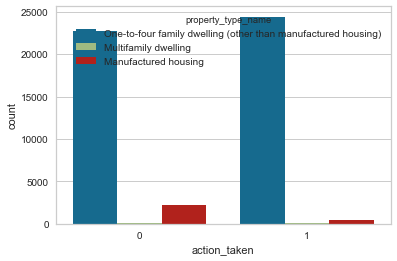

In [4]:
sns.countplot(x='action_taken', hue='property_type_name', data=DATA,)

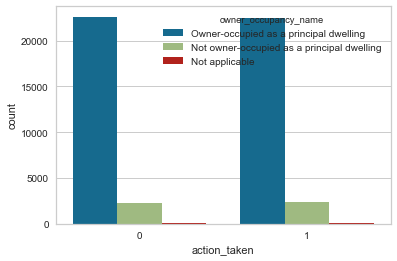

In [5]:
sns.countplot(x='action_taken', hue='owner_occupancy_name', data=DATA,)

In [6]:
meta = {
    'target_names': [str(yi) for yi in y.unique()],
    'feature_names': list(X.columns),
    'categorical_features': {
        column: list(X[column].unique())
        for column in X.columns
        if X[column].dtype == 'object'
    },
}

with open('data/meta.json', 'w') as f:
     json.dump(meta, f, indent=2)

From Dr. Bengfort's Census Notebook:

This code creates a `meta.json` file by inspecting the data frame that we have constructued. The `target_names` column, is just the two unique values in the `data.income` series; by using the `pd.Series.unique` method - we're guarenteed to spot data errors if there are more or less than two values. The `feature_names` is simply the names of all the columns. 

Now that we have everything we need stored on disk, we can create a `load_data` function, which will allow us to load the training and test datasets appropriately from disk and store them in a `Bunch`: 

In [7]:
def load_data(root=os.getcwd()):
    # Construct the `Bunch` for the HMDA dataset
    filenames     = {
        'meta': os.path.join(root, 'data','meta.json'),
        'rdme': os.path.join("..",'readme.md'),
        'data': os.path.abspath(os.path.join( "..", "fixtures", "hmda2017sample_balanced_formatted.csv")),
    }

    # Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)
        target_names  = meta['target_names']
        feature_names = meta['feature_names']

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()

    # Load the dataset from the text file.
    dataset = pd.read_csv(filenames['data'], low_memory=False)

    # Extract the target from the data
    data = dataset[[col for col in DATA.columns if col != 'action_taken']]
    target = dataset['action_taken']

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        categorical_features = meta['categorical_features'], 
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print(dataset.data.shape)

(50000, 23)


From Dr. Bengfort's Census Notebook:

Now that we've finally acheived our feature extraction, we can continue on to the model build phase. To create our classifier, we're going to create a [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that uses our feature transformers and ends in an estimator that can do classification. We can then write the entire pipeline object to disk with the `pickle`, allowing us to load it up and use it to make predictions in the future. 

A pipeline is a step-by-step set of transformers that takes input data and transforms it, until finally passing it to an estimator at the end. Pipelines can be constructed using a named declarative syntax so that they're easy to modify and develop. Our pipeline is as follows:

In [8]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X

**Create Pipeline**

In [9]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, non_bool_numeric),
        ('cat', categorical_transformer, categorical)])

In [34]:
preprocessor.fit_transform(dataset.data).shape

(50000, 67)

**Test Pipeline**

In [14]:
X = dataset.data
y = dataset.target

In [ ]:
###NOTE: this is draft for TN
categorical_indexes = [
    list(dataset.data.columns).index(key) for key in dataset.categorical_features.keys()
]

tn_pipeline = Pipeline([
        ('onehot', OneHotEncoder(categorical_features=categorical_indexes)),
    ])


tn_pipeline.fit_transform(dataset.data).shape

In [15]:
#Create a list object to eventually make the below cells iteratable
models = [
    GaussianNB(), 
    BernoulliNB(),
    tree.DecisionTreeClassifier(),
    LinearDiscriminantAnalysis(),
    LogisticRegression(solver='lbfgs', max_iter=6000), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    LinearSVC(max_iter=6000),
    SGDClassifier()
]

In [26]:
def fit_and_evaluate(X, y, model, label, **kwargs):

    start  = time.time() # Start the clock! 
    #scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}

    scores = {'precision':[], 'precision_1':[], 'precision_0':[], 'recall':[], 'recall_1':[], 'recall_0':[], 'accuracy':[], 'f1':[],  'f1_1':[],  'f1_0':[]}
    
    skf = StratifiedKFold(n_splits = 12, shuffle=True, random_state=1)
    
    for train, test in skf.split(X, y):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]
        
        estimator = Pipeline(steps=[('preprocessor', clone(preprocessor)),
                      ('model', model(**kwargs))])
        
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        cr = classification_report(y_test, predicted, output_dict=True)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['precision_1'].append(cr['1']['precision'])
        scores['precision_0'].append(cr['0']['precision'])
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['recall_1'].append(cr['1']['recall'])
        scores['recall_0'].append(cr['0']['recall'])
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))
        scores['f1_1'].append(cr['1']['f1-score'])
        scores['f1_0'].append(cr['0']['f1-score'])
        
    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())
    
    # Write official estimator to disk
    estimator = Pipeline(steps=[('preprocessor', clone(preprocessor)),
                      ('model', model(**kwargs))])
    estimator.fit(X, y)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)

    print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [27]:
fit_and_evaluate(X, y, LogisticRegression, "HMDA Logistic Regression", max_iter=6000)

Build and Validation of HMDA Logistic Regression took 16.369 seconds
Validation scores are as follows:

precision      0.720686
precision_1    0.742438
precision_0    0.698935
recall         0.718520
recall_1       0.669280
recall_0       0.767759
accuracy       0.718520
f1             0.717829
f1_1           0.703941
f1_0           0.731717
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-logistic-regression.pickle


In [18]:
###NOTE: this is the underlying code I used tonight to edit the fit_and_evaluate function

from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
model = Pipeline(steps=[('preprocessor', clone(preprocessor)),
                      ('model', LogisticRegression(max_iter=6000))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, output_dict=True))
cr = classification_report(y_test, y_pred, output_dict=True)
print("Classification report for classifier:\n%s\n"
      % (metrics.classification_report(y_test, y_pred)))

In [28]:
fit_and_evaluate(X, y, RandomForestClassifier, "HMDA Random Forest Classifier", n_estimators=100)

Build and Validation of HMDA Random Forest Classifier took 106.108 seconds
Validation scores are as follows:

precision      0.723169
precision_1    0.744237
precision_0    0.702101
recall         0.721139
recall_1       0.674000
recall_0       0.768279
accuracy       0.721139
f1             0.720506
f1_1           0.707340
f1_0           0.733673
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-random-forest-classifier.pickle


In [29]:
fit_and_evaluate(X, y, LinearDiscriminantAnalysis, "HMDA Linear Discriminant Analysis")

Build and Validation of HMDA Linear Discriminant Analysis took 10.902 seconds
Validation scores are as follows:

precision      0.720707
precision_1    0.744410
precision_0    0.697005
recall         0.718140
recall_1       0.664480
recall_0       0.771799
accuracy       0.718140
f1             0.717319
f1_1           0.702156
f1_0           0.732483
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-linear-discriminant-analysis.pickle


In [30]:
fit_and_evaluate(X, y, LinearSVC, "HMDA LinearSVC")

Build and Validation of HMDA LinearSVC took 125.161 seconds
Validation scores are as follows:

precision      0.721181
precision_1    0.742348
precision_0    0.700013
recall         0.719140
recall_1       0.671320
recall_0       0.766959
accuracy       0.719140
f1             0.718492
f1_1           0.705035
f1_0           0.731948
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-linearsvc.pickle


In [31]:
fit_and_evaluate(X, y, BernoulliNB, "HMDA BernoulliNB")

Build and Validation of HMDA BernoulliNB took 6.087 seconds
Validation scores are as follows:

precision      0.699214
precision_1    0.777253
precision_0    0.621176
recall         0.668600
recall_1       0.472641
recall_0       0.864559
accuracy       0.668600
f1             0.655328
f1_1           0.587743
f1_0           0.722912
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-bernoullinb.pickle


In [32]:
fit_and_evaluate(X, y, GaussianNB, "HMDA GaussianNB")

Build and Validation of HMDA GaussianNB took 7.559 seconds
Validation scores are as follows:

precision      0.767301
precision_1    0.967059
precision_0    0.567544
recall         0.618000
recall_1       0.244361
recall_0       0.991640
accuracy       0.618000
f1             0.555989
f1_1           0.390067
f1_0           0.721911
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-gaussiannb.pickle


In [33]:
fit_and_evaluate(X, y, tree.DecisionTreeClassifier, "HMDA DecisionTreeClassifier")

Build and Validation of HMDA DecisionTreeClassifier took 16.520 seconds
Validation scores are as follows:

precision      0.647547
precision_1    0.646008
precision_0    0.649087
recall         0.647501
recall_1       0.652920
recall_0       0.642082
accuracy       0.647501
f1             0.647472
f1_1           0.649412
f1_0           0.645531
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-decisiontreeclassifier.pickle


In [35]:
fit_and_evaluate(X, y, BaggingClassifier, "HMDA BaggingClassifier")     

Build and Validation of HMDA BaggingClassifier took 77.598 seconds
Validation scores are as follows:

precision      0.701842
precision_1    0.733064
precision_0    0.670620
recall         0.697000
recall_1       0.619680
recall_0       0.774320
accuracy       0.697000
f1             0.695173
f1_1           0.671605
f1_0           0.718740
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-baggingclassifier.pickle


In [36]:
fit_and_evaluate(X, y, ExtraTreesClassifier, "HMDA ExtraTreesClassifier", n_estimators=100)

Build and Validation of HMDA ExtraTreesClassifier took 114.045 seconds
Validation scores are as follows:

precision      0.707794
precision_1    0.718157
precision_0    0.697431
recall         0.707219
recall_1       0.682359
recall_0       0.732079
accuracy       0.707219
f1             0.707018
f1_1           0.699747
f1_0           0.714290
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-extratreesclassifier.pickle


In [37]:
fit_and_evaluate(X, y, SGDClassifier, "HMDA SGDClassifier")

Build and Validation of HMDA SGDClassifier took 6.031 seconds
Validation scores are as follows:

precision      0.706074
precision_1    0.734323
precision_0    0.677826
recall         0.675019
recall_1       0.623497
recall_0       0.726541
accuracy       0.675019
f1             0.661911
f1_1           0.643871
f1_0           0.679950
dtype: float64

Fitted model written to:
C:\Users\akx00\Desktop\gtfiles\capstone\foo\hmda-sgdclassifier.pickle


The last step is to save our model to disk for reuse later, with the `pickle` module:

In [ ]:
import pickle 

def dump_model(model, path='data', name='classifier.pickle'):
    with open(os.path.join(path, name), 'wb') as f:
        pickle.dump(model, f)
        
dump_model(census)

You should also dump meta information about the date and time your model was built, who built the model, etc. But we'll skip that step here, since this post serves as a guide. 

## Model Operation 

Now it's time to explore how to use the model. To do this, we'll create a simple function that gathers input from the user on the command line, and returns a prediction with the classifier model. Moreover, this function will load the pickled model into memory to ensure the latest and greatest saved model is what's being used. 

In [ ]:
def load_model(path='data/classifier.pickle'):
    with open(path, 'rb') as f:
        return pickle.load(f) 


def predict(model, meta=dataset):
    data = {} # Store the input from the user
    
    for column in meta['feature_names'][:-1]:
        # Get the valid responses
        valid = meta['categorical_features'].get(column)
    
        # Prompt the user for an answer until good 
        while True:
            val = " " + input("enter {} >".format(column))
            if valid and val not in valid:
                print("Not valid, choose one of {}".format(valid))
            else:
                data[column] = val
                break
    
    # Create prediction and label 
    yhat = model.predict(pd.DataFrame([data]))
    return yencode.inverse_transform(yhat)
            
    
# Execute the interface 
model = load_model()
predict(model)